# Ön Bilgi
**Geliştiren :** Onur Kantar - Ömer Resul Ertan

**Veri Kümesi Adı :** Milliyet

**Veri Kümesinin İçeriği :** 9 farklı sınıfa ait toplamda 9000 haber

**Algoritma :** Convolutional Neural Network (CNN)

**Ağ Mimarisi :** 

- Conv1D(8 x 4)
- Conv1D(4 x 2)
- GlobalMaxPooling1D
- Dense(9)


**batch_size :** 128

**epochs :** 5

**Doğruluk Oranı :** ~%89


---



In [ ]:
import pandas as pd                     
import re
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Dense
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data Sets/milliyet.csv", sep=';', encoding="ISO-8859–9")
df = df.drop(['ItemID'], axis=1)
df

,Sentiment,SentimentText
0,1,başka dünyanın çocukları 1 ocak sabahından be...
1,1,hepsi nin kızları yerli sevmez mi heygir...
2,1,2009 da ülkemizdeki sağlık harcamaları ve alın...
3,1,laktozsuz sütü kimler içmeli bir bardak süt ...
4,1,2009 trendleri ve içimizdeki alışveriş canavar...
...,...,...
8995,9,h l mı eğer h l bu memlekette kadın erkek ...
8996,9,aşk böceği özellikle haziran ve temmuz ayla...
8997,9,akp karavanı anayasa değişikliği ne getiriyor...
8998,9,boncuk bulma bizim apartmanın içerden ve dış...


# Veri Kümemizi Düzenleyelim : 

---



### NULL Değerleri Silme İşlemi

In [ ]:
df.isnull().sum()

Sentiment        0
SentimentText    0
dtype: int64

In [ ]:
# NULL Değer Bulunmuyor.
# df = df.dropna().reset_index(drop=True)
# df.isnull().sum()

### Gereksiz Verileri Kaldıralım  

In [ ]:
nltk.download('stopwords')
stop_word_list = stopwords.words('turkish')
stop_word_list

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['acaba',
 'ama',
 'aslında',
 'az',
 'bazı',
 'belki',
 'biri',
 'birkaç',
 'birşey',
 'biz',
 'bu',
 'çok',
 'çünkü',
 'da',
 'daha',
 'de',
 'defa',
 'diye',
 'eğer',
 'en',
 'gibi',
 'hem',
 'hep',
 'hepsi',
 'her',
 'hiç',
 'için',
 'ile',
 'ise',
 'kez',
 'ki',
 'kim',
 'mı',
 'mu',
 'mü',
 'nasıl',
 'ne',
 'neden',
 'nerde',
 'nerede',
 'nereye',
 'niçin',
 'niye',
 'o',
 'sanki',
 'şey',
 'siz',
 'şu',
 'tüm',
 've',
 'veya',
 'ya',
 'yani']

In [ ]:
def preprocess_text(sen):
    
    # URL Silme İşlemi
    sentence = re.sub(r'http\S+', '', str(sen))

    # E-Mail Adresi Silme İşlemi
    sentence = re.sub('\S+@\S+', '', str(sentence))

    # Sayıları Silme İşlemi
    sentence = re.sub('[\d\s]', ' ', str(sentence))

    # Noktalama İşaretlerini Silme İşlemi
    sentence = re.sub('[^\w\s]', ' ', str(sentence))
    
    # Tek Karakterleri Silme İşlemi
    sentence = re.sub(r"\b[\w\s]\b", ' ',str(sentence))
    
    # Birden Çok Boşluğu Silme İşlemi
    sentence = re.sub(r'\s+', ' ', sentence)
        
    # Engellenecek Kelimeleri Silme İşlemi
    WPT = nltk.WordPunctTokenizer()
    tokens = WPT.tokenize(sentence)
    filtered_tokens = [token for token in tokens if token not in stop_word_list]
    single_doc = ' '.join(filtered_tokens)
    
    # Tüm Harfler Küçük Harfe Dönüştürülüyor
    return single_doc.lower()

In [ ]:
x = df['SentimentText']
y = df['Sentiment']

In [ ]:
x = x.apply(preprocess_text)
pd.DataFrame(data=x)

,SentimentText
0,başka dünyanın çocukları ocak sabahından beri ...
1,nin kızları yerli sevmez mi heygirl dergisinin...
2,ülkemizdeki sağlık harcamaları alınması gereke...
3,laktozsuz sütü kimler içmeli bir bardak süt iç...
4,trendleri içimizdeki alışveriş canavarı yurtdı...
...,...
8995,memlekette kadın erkek eşitliği tartışılıyorsa...
8996,aşk böceği özellikle haziran temmuz aylarının ...
8997,akp karavanı anayasa değişikliği getiriyor çoc...
8998,boncuk bulma bizim apartmanın içerden dışardan...


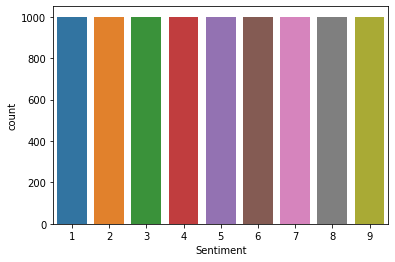

In [ ]:
sns.countplot(y)

# X Verilerimizi Düzenleyelim :

## Vektörlere Dönüştürelim

Veri setimizin işlenebilmesi için text verileri numaralara çevirmemiz gerekir.


In [ ]:
token = Tokenizer()
# Her kelimenin sıklığını hesaplar
token.fit_on_texts(x)
# Tüm kelimeleri sayı dizisine dönüştürür
x = token.texts_to_sequences(x)
# Bütün metinlerimiz en uzun kelimeden oluşan metnimiz kadar sütundan oluşan (3560) bir dizi ile temsil edilecek.
# 3560'den kısa metinlerin boşlukları 0'lar ile doldurulacak.
x = pad_sequences(x)

In [ ]:
pd.DataFrame(x).sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3520,3521,3522,3523,3524,3525,3526,3527,3528,3529,3530,3531,3532,3533,3534,3535,3536,3537,3538,3539,3540,3541,3542,3543,3544,3545,3546,3547,3548,3549,3550,3551,3552,3553,3554,3555,3556,3557,3558,3559
2668,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,24976,390,18459,14631,6,44333,30874,8211,778,161191,108813,22,108814,881,108815,6968,1357,3794,4157,5563,51922,22,956,34237,249,14631,725,7,33,1,32153,17858,10927,12530,108816,7897,15,1,2058,1158
8833,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,14,491,2335,5136,74841,45131,18184,186,277,442,61928,10614,43633,14,35,20,1,4617,130,54316,9194,2360,239058,2360,239059,5258,4377,2249,86363,1809,1580,85,1580,5864,28956,153,3495,30,8114,841
1710,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,3,41,13948,394,5909,1693,2584,25467,3586,48006,11597,65,91,216,15568,361,6877,10220,5550,17068,349,8,685,15,2599,1149,2020,1,240,11119,932,150980,2,3,64820,1459,10173,117,255
5419,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,8036,4197,343,10768,2004,764,108,2777,6690,3021,5637,3368,68953,213,981,2236,1,285,7795,197700,137,343,37365,1861,722,13,47,3,66,880,2104,846,419,2373,627,143,2373,944,735,90647
453,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,18840,210,2319,1153,888,22530,3400,19219,5206,19855,6182,4965,259,3000,934,3578,11492,1,6373,6149,2195,31691,5243,393,552,5489,17623,6726,4227,2424,2195,39162,136417,1650,351,17655,1411,351,8266,66087


## Ölçeklendirelim

**Verileri Ölçeklendirme Nedir?**

Ölçeklendirme dediğimiz şey veri setindeki iki farklı özelliğin (değişkenin) değerlerini en doğru şekilde analiz edebilmemize olanak sağlayan bir yöntemdir.

- Verilerinizin dağılımının ortalama değeri 0 ve standart sapma değeri 1 olacak şekilde değiştiriyoruz (Standartlaştırma).
- Tutarlılık oluşuyor. Bir veri diğer verilerden daha büyükse diğerleri üzerinde egemenlik kurabilir. Bunu istemeyiz.
- Bir öğrenme modeliyle çalışırken, özellikleri sıfır merkezli bir aralığa ölçeklemek önemlidir.
- Değerleri karşılaştırmak yerine oranları karşılaştırmış oluruz.

In [ ]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [ ]:
pd.DataFrame(x).sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3520,3521,3522,3523,3524,3525,3526,3527,3528,3529,3530,3531,3532,3533,3534,3535,3536,3537,3538,3539,3540,3541,3542,3543,3544,3545,3546,3547,3548,3549,3550,3551,3552,3553,3554,3555,3556,3557,3558,3559
6981,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,...,-0.394338,1.571752,-0.388363,-0.429827,-0.414796,-0.432798,-0.434877,-0.436675,1.520164,-0.448685,-0.182451,-0.442230,-0.056055,-0.426050,-0.438170,-0.382940,-0.401962,-0.422623,-0.445324,-0.406288,0.473393,-0.376783,0.003954,-0.221406,1.050600,-0.438491,-0.331501,-0.435361,-0.435537,-0.423952,-0.323198,-0.434067,-0.421338,-0.448789,-0.066832,-0.449718,-0.416886,-0.418754,-0.203867,-0.516224
8463,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,...,-0.434930,-0.428676,-0.390819,-0.429614,-0.169720,-0.418054,-0.161260,-0.439793,-0.320249,5.788914,-0.286750,0.553109,0.026908,0.999170,-0.431475,-0.443661,-0.398933,-0.423648,1.214268,0.594775,1.461199,-0.437154,-0.035408,-0.389703,0.587681,-0.407608,-0.419179,0.078555,-0.408790,-0.380933,-0.438780,-0.452659,-0.353355,1.408284,-0.387045,0.583567,0.306239,-0.400508,-0.151926,-0.517301
5095,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,...,-0.426289,-0.431686,-0.395441,-0.415585,-0.278574,-0.441342,-0.386797,2.691184,-0.411503,-0.353244,-0.162507,-0.432226,-0.267237,-0.434974,-0.434294,-0.444067,-0.441546,-0.441747,-0.299384,1.856684,-0.419296,-0.437236,-0.436979,-0.439939,-0.447392,-0.263013,-0.242828,-0.432385,-0.339816,-0.438265,-0.437605,-0.327507,-0.446951,-0.334125,-0.370246,-0.429345,-0.444369,-0.410803,-0.425232,-0.517236
3985,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,...,-0.390768,-0.437707,-0.438810,-0.436615,0.840745,-0.393633,-0.417632,-0.284424,-0.434118,-0.311627,-0.447104,-0.441037,-0.422490,0.370022,0.905145,0.107054,4.180231,-0.409147,-0.445484,-0.350599,-0.439782,-0.399717,-0.342122,1.988307,-0.442541,-0.438869,-0.248670,0.049517,-0.434643,-0.322269,-0.198409,0.710247,-0.422273,4.066482,0.954983,-0.448618,-0.428309,-0.438988,-0.436612,0.184434
5890,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,...,-0.418114,-0.361533,-0.436037,-0.436828,-0.432441,-0.306435,-0.366114,

## CNN için x'i 3 Boyutlu Hale Getirelim

In [ ]:
print('x : ' + str(x.shape))

x : (9000, 3560)


In [ ]:
x = np.reshape(x, (x.shape[0], x.shape[1], 1))
print('x : ' + str(x.shape))

x : (9000, 3560, 1)


# Y Verilerimizi Düzenleyelim :  


---

## One Hot Encoding Uygulayalım

**One Hot Encoding Nedir?**

One Hot Encoding, kategorik değişkenlerin ikili (binary) olarak temsil edilmesi anlamına gelmektedir. Bu işlem, ağın model için problemi daha kolay hale getirmesine yardımcı olabilir. Hataları engeller ve daha hızlı çalışmasını sağlar. 

- Bu işlem ilk önce kategorik değerlerin tamsayı değerleriyle eşlenmesini gerektirir.
- Daha sonra, her bir tamsayı değeri, 1 ile işaretlenmiş tamsayı indeksi dışındaki tüm değerleri   sıfır  olan bir ikili vektör olarak temsil edilir.

In [ ]:
pd.DataFrame(y).sample(5)

,Sentiment
5133,6
3982,4
2997,3
7369,8
52,1


In [ ]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
pd.DataFrame(y).sample(5)

,0
1493,1
2549,2
5179,5
2737,2
7284,7


In [ ]:
y = to_categorical(y)
pd.DataFrame(y).sample(5)

,0,1,2,3,4,5,6,7,8
5091,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1114,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3749,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2408,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4911,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Train ve Test İşlemleri İçin Ayrımı Gerçekleştirelim : 

---


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [ ]:
print('x Train : ' + str(x_train.shape))
print('x Test : ' + str(x_test.shape))
print('y Train : ' + str(y_train.shape))
print('y Test : ' + str(y_test.shape))

x Train : (7200, 3560, 1)
x Test : (1800, 3560, 1)
y Train : (7200, 9)
y Test : (1800, 9)


# Katmanları Oluşturup Eğitime Başlayalım : 

---


In [ ]:
model = Sequential()

model.add(Conv1D(8, 4, activation='relu', strides=1, input_shape=(x_train.shape[1], 1)))

model.add(Conv1D(4, 2, activation='relu', strides=1))

model.add(GlobalMaxPooling1D())

model.add(Dense(9, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

history = model.fit(x_train, y_train, batch_size=128, epochs=5, verbose=1, validation_data = (x_test, y_test))

Train on 7200 samples, validate on 1800 samples
Epoch 1/5
7200/7200 [==============================] - 10s 1ms/step - loss: 0.9575 - acc: 0.5624 - val_loss: 0.7621 - val_acc: 0.6258
Epoch 2/5
7200/7200 [==============================] - 10s 1ms/step - loss: 0.6638 - acc: 0.6810 - val_loss: 0.5838 - val_acc: 0.7768
Epoch 3/5
7200/7200 [==============================] - 10s 1ms/step - loss: 0.5312 - acc: 0.7972 - val_loss: 0.4813 - val_acc: 0.8075
Epoch 4/5
7200/7200 [==============================] - 10s 1ms/step - loss: 0.4482 - acc: 0.8746 - val_loss: 0.4190 - val_acc: 0.8889
Epoch 5/5
7200/7200 [==============================] - 10s 1ms/step - loss: 0.4070 - acc: 0.8889 - val_loss: 0.3930 - val_acc: 0.8889


In [ ]:
score = model.evaluate(x_test, y_test, verbose = 0)

In [ ]:
print('Validation Loss :', score[0])
print('Validation Accuracy :', score[1])

Validation Loss : 0.3930247521400452
Validation Accuracy : 0.8888892531394958


# Sonuçları Değerlendirelim :

---


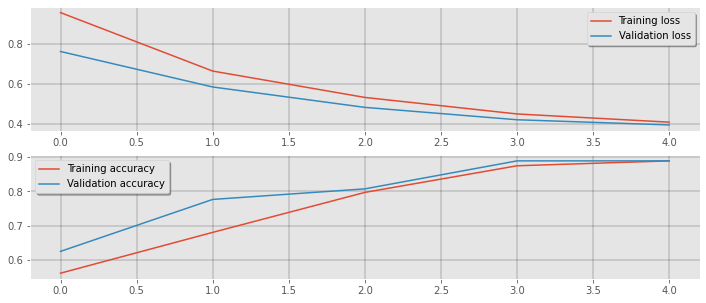

In [ ]:
plt.style.use('ggplot')

fig, ax = plt.subplots(2, 1, figsize=(12,5))
ax[0].plot(history.history['loss'], label="Training loss")
ax[0].plot(history.history['val_loss'], label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], label="Training accuracy")
ax[1].plot(history.history['val_acc'], label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)